In [1]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import string
import sqlalchemy
import unicodedata
import tqdm
import warnings
warnings.filterwarnings('ignore')

########################################
# external libs
########################################
import joblib
from joblib import delayed, Parallel

########################################
# ml
########################################
from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = -1
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# LOGS
#################################
with open(os.path.join(BASE_DIR, 'log.conf.yaml'), 'r') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)

In [2]:
class TextCleaner(BaseEstimator, TransformerMixin):
    stop_words = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no',
                  'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu',
                  'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo',
                  'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem',
                  'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu',
                  'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe',
                  'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes',
                  'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas',
                  'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está',
                  'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam',
                  'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos',
                  'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve',
                  'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse',
                  'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos',
                  'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram',
                  'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos',
                  'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos',
                  'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos',
                  'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem',
                  'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']

    def __init__(self, n_jobs=1):
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sX = pd.Series(X)

        def tratar_texto(t):

            if not t:
                return ''
            if type(t) != str:
                t = str(t)

            t = t.replace('\\n', ' ')
            t = t.replace('null', ' ')
            t = t.lower()
            regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
            t = regex.sub(" ", t)
            lista = t.split()

            # retira stopwords e sinais de pontuação
            lista = [palavra for palavra in lista if palavra not in self.stop_words and palavra not in string.punctuation]

            # retira os dígitos
            lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
            lista = lista.replace('\n', ' ').replace('\r', ' ')
            lista = lista.replace(' o ', ' ').replace(' a ', ' ').replace(' os ', ' ').replace(' as ',
                                                                                               ' ')  # retira o, a, os, as que ainda permaneceiam no texto
            lista = re.sub(r" +", ' ', lista)  # retira espaços em excesso

            nfkd = unicodedata.normalize('NFKD', lista)
            lista = u"".join([c for c in nfkd if not unicodedata.combining(c)])  # retira acento

            return lista

        def tratar_serie(s):
            return s.apply(tratar_texto)

        split = np.array_split(sX, self.n_jobs)
        r = Parallel(n_jobs=self.n_jobs, verbose=0)(delayed(tratar_serie)(s) for s in split)
        return pd.concat(r)


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, default_value=0):
        self.feature_names = feature_names
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # incluir teste para colunas ausentes
        X = X.copy()
        for c in self.feature_names:
            if c not in X.columns:
                X[c] = self.default_value
        return X[self.feature_names]

In [3]:
# manter no dataset apenas manifestacoes até maio
# sdp = sqlalchemy.create_engine('mssql+pyodbc://xxxxxxxxxxx')
# query = """
# SELECT [IdManifestacao]
# FROM [db_denuncias_origem].[eouv].[Manifestacao]
# WHERE [DatRegistro] < convert(datetime, '01/06/2021', 103)
# ORDER BY [DatRegistro] desc
# """
# df_datas = pd.read_sql(query, sdp)
# df_datas = pd.read_csv('datasets/manifestacoes_ate_20210531.csv')

In [4]:
# Leitura dos dados estruturados extraídos das denúncias. 
# df = pd.read_parquet('datasets/df_treinamento_faro.parquet')
# df = df[df['IdManifestacao'].isin(df_datas['IdManifestacao'])].copy()
# df_anonimizado = df.copy()
# df_anonimizado['LABEL'] = df_anonimizado['GrauAptidao'].apply(lambda x: 1 if x > 50 else 0)
# df_anonimizado.drop(columns=['IdManifestacao','GrauAptidao','TxtFatoManifestacao','TextoAnexo'], inplace=True)
# df_anonimizado.columns = [f'F{i:>03}' for i, c in enumerate(df_anonimizado.columns[:-1])] + ['LABEL']
# df = df_anonimizado

# # Divisão dos dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['LABEL']), df['LABEL'], test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=df['LABEL'])

# # altera a escala das features para um intervalo entre 0 e 1.
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

df_train = pd.read_parquet('datasets/df_train_de.parquet')
X_train, y_train = df_train.drop(columns=['LABEL']), df_train['LABEL']

df_test = pd.read_parquet('datasets/df_test_de.parquet')
X_test, y_test = df_test.drop(columns=['LABEL']), df_test['LABEL']

NUMERO_FEATURES = X_train.shape[1]

# Modelo baseado em dados estruturados

In [5]:
# cálculo do peso para a classe positiva (utilizado em algoritmos que podem lidar com o dataset desbalanceado)
POS_WEIGHT = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight = {0: 1, 1: POS_WEIGHT}

k = 20
selector_model=RandomForestClassifier(
    n_estimators=1000, 
    class_weight=class_weight, 
    random_state=DEFAULT_RANDOM_STATE, 
    n_jobs=N_JOBS)

selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [6]:
# hiperparâmetros escolhidos na otimização
params = [2958, 6, 2, 5, 0.5019469401405005, 3]
n_estimators = params[0] 
max_depth = params[1]
min_samples_split = params[2]
min_samples_leaf = params[3]
max_samples = params[4]
class_weight = {0: 1, 1: params[5]}

model_de = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_samples=max_samples,
                             class_weight=class_weight,
                             random_state=DEFAULT_RANDOM_STATE, 
                             n_jobs=-1)

model_de.fit(X_train, y_train)

p_de = model_de.predict(X_test)

In [7]:
round(balanced_accuracy_score(y_test, p_de),2)

0.7

In [8]:
round(roc_auc_score(y_test, model_de.predict_proba(X_test)[:,1]),4)

0.784

In [9]:
print(confusion_matrix(y_test, p_de))

[[326 244]
 [ 41 200]]


In [10]:
print(classification_report(y_test, p_de))

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       570
           1       0.45      0.83      0.58       241

    accuracy                           0.65       811
   macro avg       0.67      0.70      0.64       811
weighted avg       0.76      0.65      0.66       811



In [11]:
round(f1_score(y_test, p_de, average='macro',),2)

0.64

In [12]:
round(average_precision_score(y_test, model_de.predict_proba(X_test)[:,1]),4)

0.5499

In [13]:
proba_estruturado = model_de.predict_proba(X_test)[:,1]

# Modelo baseado em textos

In [14]:
# #df = pd.read_parquet('dados_nao_anonimizados/df_completo_rotulado.parquet')
# df = pd.read_parquet('datasets/df_treinamento_faro.parquet')
# df = df[df['IdManifestacao'].isin(df_datas['IdManifestacao'])].copy()
# df['TextoCompleto'] = df['TxtFatoManifestacao'].str.cat(df['TextoAnexo'], sep=' ').astype(str)
# X_txt, y_txt = df[['TextoCompleto']], df['GrauAptidao'].apply(lambda x: 1 if x>50 else 0)

In [15]:
# # preprocessamento do texto (remoção de stopwords, remoção de acentos, remoção de pontuações, remoção de números, transformação de todos os caracteres em lowercase)

# X_txt_train = X_txt.loc[y_train.index, :].copy()
# y_txt_train = y_txt.loc[y_train.index].copy()
# X_txt_test = X_txt.loc[y_test.index, :].copy()
# y_txt_test = y_txt.loc[y_test.index].copy()

# X_txt_train = TextCleaner(n_jobs=N_JOBS).fit_transform(X_txt_train['TextoCompleto']).to_frame()
# X_txt_test = TextCleaner(n_jobs=N_JOBS).fit_transform(X_txt_test['TextoCompleto']).to_frame()

In [16]:
df_train = pd.read_parquet('datasets/df_train_txt.parquet')
X_txt_train_idf, y_txt_train = df_train.drop(columns=['LABEL']), df_train['LABEL']

df_test = pd.read_parquet('datasets/df_test_txt.parquet')
X_txt_test_idf, y_txt_test = df_test.drop(columns=['LABEL']), df_test['LABEL']

In [17]:
params = [833, 5, 1.2539682234528862, 0.01237044939876533, 0.8533306831258293, 1.1517028458031964, 0.39412975004567713]
scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]
n_estimators = params[0] 
max_depth = params[1]
reg_lambda = params[2]
learning_rate = params[3]
subsample = params[4]
reg_alpha = params[5]
gamma = params[6]

scale_pos_weight = y_txt_train.value_counts()[0]/y_txt_train.value_counts()[1]

model_txt = XGBClassifier(base_score=None, colsample_bylevel=None,
           colsample_bynode=None, colsample_bytree=None, gamma=gamma,
           gpu_id=None, importance_type='gain', interaction_constraints=None,
           learning_rate=learning_rate, max_delta_step=None, max_depth=max_depth,
           n_estimators=n_estimators, n_jobs=None, num_parallel_tree=None,
           random_state=DEFAULT_RANDOM_STATE, reg_alpha=reg_alpha, reg_lambda=reg_lambda,
           scale_pos_weight=scale_pos_weight, subsample=subsample, tree_method=None,
           validate_parameters=None, verbosity=None)

model_txt.fit(X_txt_train_idf, y_txt_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.39412975004567713,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.01237044939876533, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=833, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=1.1517028458031964, reg_lambda=1.2539682234528862,
              scale_pos_weight=2.371488033298647, subsample=0.8533306831258293,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
round(balanced_accuracy_score(y_txt_test, model_txt.predict(X_txt_test_idf) ),2)

0.73

In [19]:
round(roc_auc_score(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:, 1] ),4)

0.8148

In [20]:
print(classification_report(y_txt_test, model_txt.predict(X_txt_test_idf) ))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       570
           1       0.56      0.69      0.62       241

    accuracy                           0.75       811
   macro avg       0.71      0.73      0.72       811
weighted avg       0.77      0.75      0.76       811



In [21]:
print(confusion_matrix(y_txt_test, model_txt.predict(X_txt_test_idf) ))

[[442 128]
 [ 75 166]]


In [22]:
round(f1_score(y_txt_test, model_txt.predict(X_txt_test_idf), average='macro'),2)

0.72

In [23]:
round(average_precision_score(y_txt_test,model_txt.predict_proba(X_txt_test_idf)[:, 1]),4)

0.652

In [24]:
proba_texto = model_txt.predict_proba(X_txt_test_idf)[:, 1]

# Modelos Combinados

In [25]:
proba_de = model_de.predict_proba(X_test)[:, 1]
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:, 1]

In [26]:
y_test[:5], y_txt_test[:5]

(1511    0
 1365    0
 1722    0
 3327    0
 2087    0
 Name: LABEL, dtype: int64,
 1511    0
 1365    0
 1722    0
 3327    0
 2087    0
 Name: LABEL, dtype: int64)

In [27]:
np.corrcoef(proba_de, proba_txt)

array([[1.        , 0.57999121],
       [0.57999121, 1.        ]])

In [28]:
def calc_label(v):
    if v >= .5:
        return 1
    else:
        return 0
calc_label_v = np.vectorize(calc_label)

# média

In [29]:
p_comb_v01 = (proba_de + proba_txt)/2

In [30]:
print(confusion_matrix(y_test, calc_label_v(p_comb_v01)))

[[411 159]
 [ 48 193]]


In [31]:
print(classification_report(y_test, calc_label_v(p_comb_v01)))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       570
           1       0.55      0.80      0.65       241

    accuracy                           0.74       811
   macro avg       0.72      0.76      0.72       811
weighted avg       0.79      0.74      0.75       811



In [32]:
round(roc_auc_score(y_test, p_comb_v01),3)

0.839

In [33]:
round(balanced_accuracy_score(y_test, calc_label_v(p_comb_v01)),3)

0.761

In [34]:
round(f1_score(y_test, calc_label_v(p_comb_v01)),3)

0.651

In [35]:
round(average_precision_score(y_test, calc_label_v(p_comb_v01)),3)

0.498

In [36]:
p = (proba_estruturado + proba_texto)/2
print(round(roc_auc_score(y_test.values, p),4))
print(round(average_precision_score(y_test.values, p),4))

0.8386
0.6719


In [37]:
p = (2*proba_estruturado + proba_texto)/3
round(roc_auc_score(y_test.values, p),3)
print(round(roc_auc_score(y_test.values, p),4))
print(round(average_precision_score(y_test.values, p),4))

0.831
0.6517


In [38]:
p = (proba_estruturado +2* proba_texto)/3
round(roc_auc_score(y_test.values, p),3)
print(round(roc_auc_score(y_test.values, p),4))
print(round(average_precision_score(y_test.values, p),4))

0.8362
0.6745


In [39]:
p = (3*proba_estruturado + 2*proba_texto)/5
round(roc_auc_score(y_test.values, p),3)
print(round(roc_auc_score(y_test.values, p),4))
print(round(average_precision_score(y_test.values, p),4))

0.8351
0.6603


In [40]:
p = (2*proba_estruturado + 3*proba_texto)/5
round(roc_auc_score(y_test.values, p),3)
print(round(roc_auc_score(y_test.values, p),4))
print(round(average_precision_score(y_test.values, p),4))

0.8378
0.6741


# maior

In [41]:
p_comb_v02 = [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)]

In [42]:
print(confusion_matrix(y_test, calc_label_v(p_comb_v02)))

[[296 274]
 [ 29 212]]


In [43]:
print(classification_report(y_test, calc_label_v(p_comb_v02)))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66       570
           1       0.44      0.88      0.58       241

    accuracy                           0.63       811
   macro avg       0.67      0.70      0.62       811
weighted avg       0.77      0.63      0.64       811



In [44]:
round(roc_auc_score(y_test.values, p_comb_v02),3)

0.814

In [45]:
round(balanced_accuracy_score(y_test.values, calc_label_v(p_comb_v02)),3)

0.699

In [46]:
round(average_precision_score(y_test, calc_label_v(p_comb_v02)),3)

0.419

In [47]:
round(f1_score(y_test, calc_label_v(p_comb_v02)),3)

0.583

# menor

In [48]:
p_comb_v03 = calc_label_v(proba_de) & calc_label_v(proba_txt)

In [49]:
print(confusion_matrix(y_test, p_comb_v03))

[[472  98]
 [ 87 154]]


In [50]:
print(confusion_matrix(y_test, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])))

[[472  98]
 [ 87 154]]


In [51]:
print(classification_report(y_test, p_comb_v03))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       570
           1       0.61      0.64      0.62       241

    accuracy                           0.77       811
   macro avg       0.73      0.73      0.73       811
weighted avg       0.78      0.77      0.77       811



In [52]:
round(roc_auc_score(y_test.values, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)]),3)

0.831

In [53]:
round(balanced_accuracy_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.734

In [54]:
round(recall_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.639

In [55]:
round(f1_score(y_test.values, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.625

In [56]:
round(average_precision_score(y_test, calc_label_v([np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])),3)

0.498

# ROC_AUC Comparativo

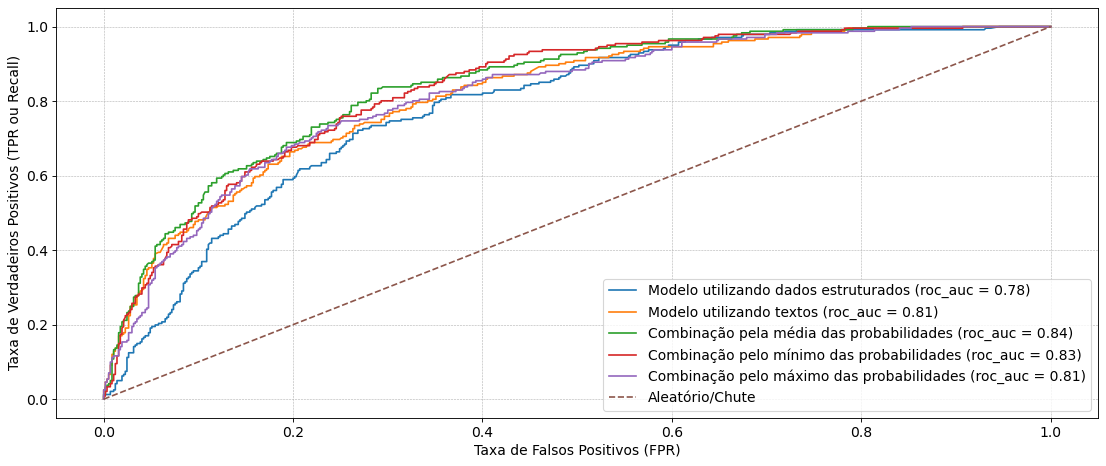

In [57]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')

proba_de = model_de.predict_proba(X_test)[:,1]
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:,1]

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, model_de.predict_proba(X_test)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, model_de.predict_proba(X_test)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando dados estruturados (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pela média das probabilidades (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.min([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pelo mínimo das probabilidades (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.max([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pelo máximo das probabilidades (roc_auc = {:.2f})'.format(score))

# lr_fpr, lr_tpr, thresholds =  roc_curve(y_test.values, , drop_intermediate=False, pos_label=1)
# plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos',color='#45B39D')


plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('./docs/tcc/fig_00600_roc_auc_texto.png')
plt.show()

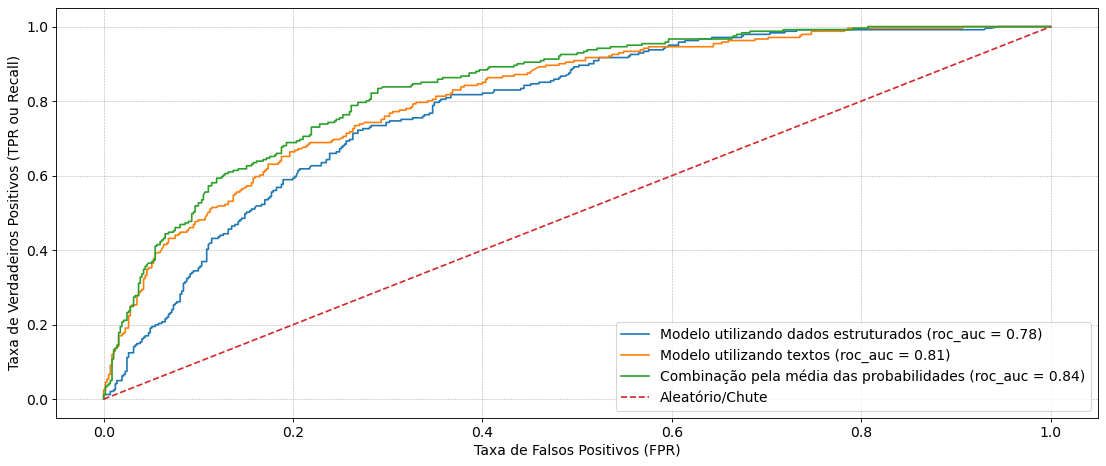

In [58]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')

proba_de = model_de.predict_proba(X_test)[:,1]
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:,1]

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, model_de.predict_proba(X_test)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, model_de.predict_proba(X_test)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando dados estruturados (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pela média das probabilidades (roc_auc = {:.2f})'.format(score))

plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./fig_roc_auc_3.png')
plt.show()

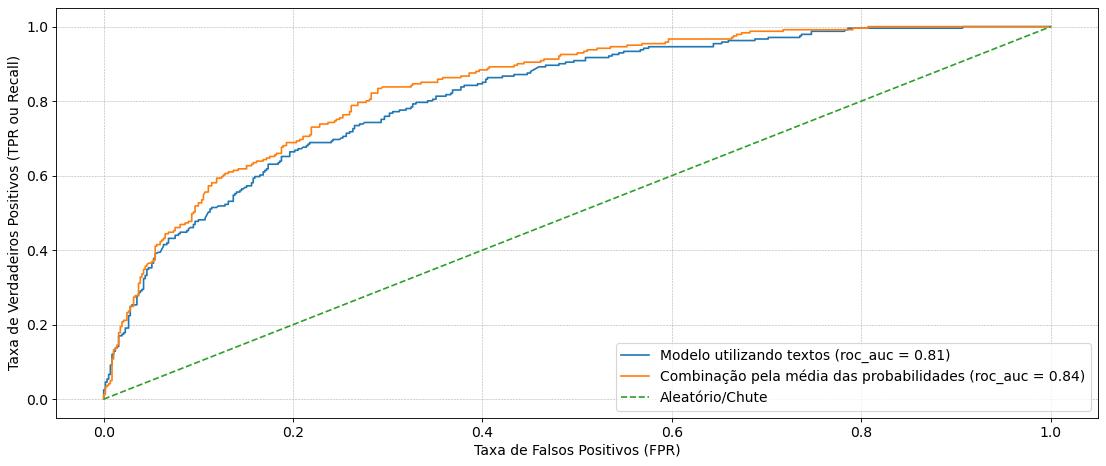

In [59]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')

proba_de = model_de.predict_proba(X_test)[:,1]
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:,1]

lr_fpr, lr_tpr, thresholds =  roc_curve(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_txt_test, model_txt.predict_proba(X_txt_test_idf)[:,1])
plt.plot(lr_fpr, lr_tpr, label='Modelo utilizando textos (roc_auc = {:.2f})'.format(score))

lr_fpr, lr_tpr, thresholds =  roc_curve(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)], drop_intermediate=False, pos_label=1)
score = roc_auc_score(y_test, [np.mean([vde, vtxt]) for vde, vtxt in zip(proba_de, proba_txt)])
plt.plot(lr_fpr, lr_tpr, label='Combinação pela média das probabilidades (roc_auc = {:.2f})'.format(score))

plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./fig_roc_auc_2.png')
plt.show()

# Intervalo de confiança

In [60]:
try:
    tqdm.tqdm._instances.clear()
except:
    pass

In [61]:
proba_de = model_de.predict_proba(X_test)[:, 1]
roc_auc_de = roc_auc_score(y_test, proba_de)
roc_auc_de

0.7839884982164955

In [62]:
proba_txt = model_txt.predict_proba(X_txt_test_idf)[:, 1]
roc_auc_txt = roc_auc_score(y_test, proba_txt)
roc_auc_txt

0.8148103661643736

In [63]:
roc_auc_score(y_test, np.mean([proba_de, proba_txt], axis=0))

0.8386256096673218

In [64]:
X_test.shape

(811, 20)

In [65]:
n = X_test.shape[0]
idx = np.random.choice(list(range(n)), size=n, replace=True)
idx

array([ 53, 363, 538, 320, 509, 685, 437, 733, 747,  88, 714, 120, 177,
       786, 193, 206, 380, 796, 627, 375, 189, 131, 370, 737, 780, 311,
       433, 261, 805, 717, 450, 322, 615, 383,  67, 524,   0, 157, 103,
       418, 647, 745, 232, 599, 245, 687, 711, 482, 792, 353, 713, 500,
       227, 423, 605, 388, 165, 519, 495, 360, 563, 176,  36, 181, 323,
       125, 581, 178, 167, 276, 122, 650, 567, 687, 673, 509, 134,  97,
       154, 153, 642, 805, 791,  93, 486, 556, 108, 115, 785, 328, 326,
       135, 484, 340, 558, 754, 803, 347, 794, 535, 681, 491, 347, 210,
       353, 386, 477, 185, 452, 306, 189, 373, 588, 143, 570, 294,  85,
       600, 370, 121, 389, 624, 302, 147, 472, 302,  35, 732, 568, 668,
       136, 656, 606, 537, 229, 747, 326, 422, 249,  39, 406, 426, 374,
       109, 416, 247, 310, 259, 450, 489,  31, 747, 291, 674, 401, 702,
       802, 195,  71, 306, 796, 122, 205, 298, 634, 686, 303,  38, 509,
       775, 424, 667, 653, 503,  59, 463, 374, 413,  15,  99, 33

In [66]:
def bootstrap(X_test: pd.core.frame.DataFrame, X_txt_test_idf: pd.core.frame.DataFrame, y_test: pd.core.frame.Series, model_de, model_txt, b_num=10, n_jobs=-1):
    n = X_test.shape[0]
    results = []
    
    def worker():
        idx = np.random.choice(list(range(n)), size=n, replace=True)
        X_test_sample = X_test.iloc[idx]
        X_txt_test_idf_sample = X_txt_test_idf.iloc[idx]
        y_test_sample = y_test.iloc[idx]
        
        proba_de = model_de.predict_proba(X_test_sample)[:, 1]
        proba_txt = model_txt.predict_proba(X_txt_test_idf_sample)[:, 1]
        roc_auc_de = roc_auc_score(y_test_sample, proba_de)
        roc_auc_txt = roc_auc_score(y_test_sample, proba_txt)
        roc_auc_mean = roc_auc_score(y_test_sample, np.mean([proba_de, proba_txt], axis=0))
        
        return {
            'roc_auc_de': roc_auc_de,
            'roc_auc_txt': roc_auc_txt,
            'roc_auc_mean': roc_auc_mean,
        }
    
    try:
        tqdm.tqdm._instances.clear()
    except:
        pass
    
    results = Parallel(n_jobs=n_jobs, verbose=0, backend='threading')(delayed(worker)() for i in tqdm.tqdm(range(b_num)))
        
    return results

bstrap = bootstrap(pd.DataFrame(X_test), X_txt_test_idf, y_test, model_de, model_txt, b_num=1000, n_jobs=4)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:59<00:00,  1.28it/s]


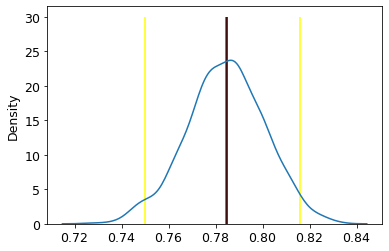

In [67]:
# Plotting PDF
sns.distplot([b['roc_auc_de'] for b in bstrap],hist=False)
m = np.mean([b['roc_auc_de'] for b in bstrap])
md = np.median([b['roc_auc_de'] for b in bstrap])
ci0, ci1 = np.percentile([b['roc_auc_de'] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='red')
plt.vlines(md, 0 ,30, color='black')
plt.vlines(ci0, 0 ,30, color='yellow')
plt.vlines(ci1, 0 ,30, color='yellow')
plt.show()

In [68]:
np.mean([b['roc_auc_de'] for b in bstrap]), np.percentile([b['roc_auc_de'] for b in bstrap],[2.5,97.5])

(0.7843113868603154, array([0.74980518, 0.81598889]))

In [69]:
np.mean([b['roc_auc_txt'] for b in bstrap]), np.percentile([b['roc_auc_txt'] for b in bstrap],[2.5,97.5])

(0.8159280576172904, array([0.78586493, 0.84626315]))

In [70]:
np.mean([b['roc_auc_mean'] for b in bstrap]), np.percentile([b['roc_auc_mean'] for b in bstrap],[2.5,97.5])

(0.8392350931664986, array([0.81047524, 0.8673534 ]))

In [71]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro([b['roc_auc_de'] for b in bstrap])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.998, p=0.403
Sample looks Gaussian (fail to reject H0)


In [72]:
np.percentile([b['roc_auc_de'] for b in bstrap],[2.5,97.5])

array([0.74980518, 0.81598889])

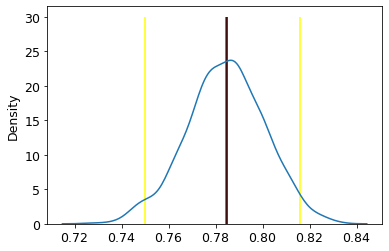

In [73]:
# Plotting PDF
v = 'roc_auc_de'
sns.distplot([b[v] for b in bstrap],hist=False)
m = np.mean([b[v] for b in bstrap])
md = np.median([b[v] for b in bstrap])
ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='red')
plt.vlines(md, 0 ,30, color='black')
plt.vlines(ci0, 0 ,30, color='yellow')
plt.vlines(ci1, 0 ,30, color='yellow')
plt.show()

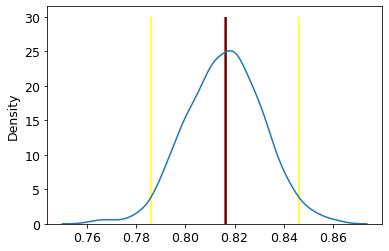

In [74]:
# Plotting PDF
v = 'roc_auc_txt'
sns.distplot([b[v] for b in bstrap],hist=False)
m = np.mean([b[v] for b in bstrap])
md = np.median([b[v] for b in bstrap])
ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='red')
plt.vlines(md, 0 ,30, color='black')
plt.vlines(ci0, 0 ,30, color='yellow')
plt.vlines(ci1, 0 ,30, color='yellow')
plt.show()

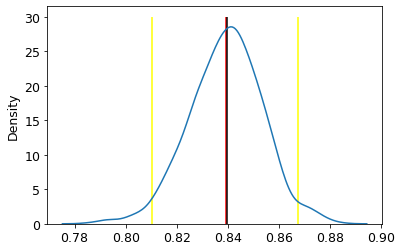

In [75]:
# Plotting PDF
v = 'roc_auc_mean'
sns.distplot([b[v] for b in bstrap],hist=False)
m = np.mean([b[v] for b in bstrap])
md = np.median([b[v] for b in bstrap])
ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='red')
plt.vlines(md, 0 ,30, color='black')
plt.vlines(ci0, 0 ,30, color='yellow')
plt.vlines(ci1, 0 ,30, color='yellow')
plt.show()

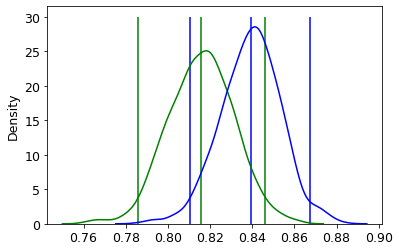

In [76]:


# # Plotting PDF
# v = 'roc_auc_de'
# sns.distplot([b[v] for b in bstrap],hist=False, color='red')
# m = np.mean([b[v] for b in bstrap])
# ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
# plt.vlines(m, 0 ,30, color='red')
# plt.vlines(ci0, 0 ,30, color='red')
# plt.vlines(ci1, 0 ,30, color='red')

v = 'roc_auc_txt'
sns.distplot([b[v] for b in bstrap],hist=False, color='green')
m = np.mean([b[v] for b in bstrap])
ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='green')
plt.vlines(ci0, 0 ,30, color='green')
plt.vlines(ci1, 0 ,30, color='green')

v = 'roc_auc_mean'
sns.distplot([b[v] for b in bstrap],hist=False, color='blue')
m = np.mean([b[v] for b in bstrap])
ci0, ci1 = np.percentile([b[v] for b in bstrap],[2.5,97.5])
plt.vlines(m, 0 ,30, color='blue')
plt.vlines(ci0, 0 ,30, color='blue')
plt.vlines(ci1, 0 ,30, color='blue')

plt.show()


# Testes de Hipótose

In [77]:
df_bs = pd.DataFrame(bstrap)
df_bs.to_parquet('datasets/df_bootstrap.parquet')

In [78]:
df_bstrap = pd.read_parquet('datasets/df_bootstrap.parquet')
df_bstrap.head()

,roc_auc_de,roc_auc_txt,roc_auc_mean
0,0.765648,0.806705,0.826930
1,0.765634,0.833875,0.842226
2,0.770884,0.794017,0.818231
3,0.765073,0.810439,0.823526
4,0.796696,0.804054,0.840139


In [79]:
txt = df_bstrap['roc_auc_txt'] # np.array([b['roc_auc_txt'] for b in bstrap])
mean = df_bstrap['roc_auc_mean'] # np.array([b['roc_auc_mean'] for b in bstrap])

In [80]:
from IPython.display import display, Markdown
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import kruskal


## Testes de Normalidade para as ROC_AUC obtidas com Bootstrap pelo Modelo Textual

$H_0$: $P_{AB} \sim N(\mu, \sigma^2)$\
$H_A$: $P_{AB} \not \sim N(\mu, \sigma^2)$\
$$  
\
$$

Ao aplicar o teste D’Agostino’s K$^2$, obtém-se $\textit{p-value}=0.1904$. Sendo $\textit{ p-value } > \alpha$, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Shapiro-Wilk, obtém-se $\textit{p-value}=0.1974$. Sendo $\textit{ p-value } > \alpha$, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Anderson-Darling, obtém-se a estatística $0.253$ e valor crítico $0.784$
para $\alpha=0.05$. Sendo a estatística menor que o valor crítico, para o nível de significância escolhido, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Assim, todos os testes e a análise gráfica confirmam a normalidade.


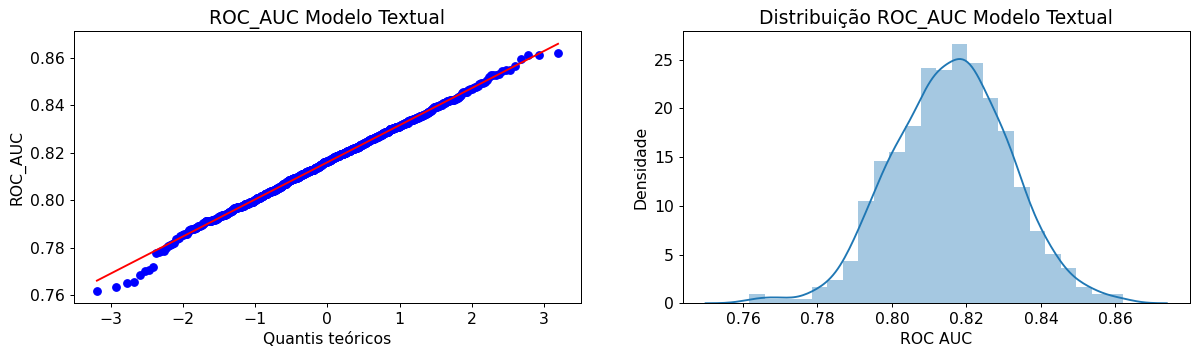

In [81]:
anderson_result = anderson(txt)

md = Markdown(f'''\

## Testes de Normalidade para as ROC_AUC obtidas com Bootstrap pelo Modelo Textual

$H_0$: $P_{{AB}} \\sim N(\\mu, \\sigma^2)$\\
$H_A$: $P_{{AB}} \\not \\sim N(\\mu, \\sigma^2)$\\
$$  
\\
$$

Ao aplicar o teste D’Agostino’s K$^2$, obtém-se $\\textit{{p-value}}={normaltest(txt)[1]:.4f}$. Sendo $\\textit{{ p-value }} > \\alpha$, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Shapiro-Wilk, obtém-se $\\textit{{p-value}}={shapiro(txt)[1]:.4f}$. Sendo $\\textit{{ p-value }} > \\alpha$, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Anderson-Darling, obtém-se a estatística ${anderson_result.statistic:.3f}$ e valor crítico ${anderson_result.critical_values[2]:.3f}$
para $\\alpha={anderson_result.significance_level[2]/100:.2f}$. Sendo a estatística menor que o valor crítico, para o nível de significância escolhido, 
não é possível rejeitar $H_0$ e aceita-se que os dados são provenientes de uma distribuição normal.

Assim, todos os testes e a análise gráfica confirmam a normalidade.
''')

display(md)

fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=90, sharex=False, sharey=False)

probplot(txt, plot=ax[0])
ax[0].set_ylabel('ROC_AUC')
ax[0].set_xlabel('Quantis teóricos')
ax[0].set_title('ROC_AUC Modelo Textual')

sns.distplot(txt, ax=ax[1])
ax[1].set_ylabel('Densidade')
ax[1].set_xlabel('ROC AUC')
ax[1].set_title('Distribuição ROC_AUC Modelo Textual')
plt.show()


## Testes de Normalidade para as ROC_AUC obtidas com Bootstrap pelo Modelo Combinado

$\alpha$ = 0,05\
\
$H_0$: $P_{AB} \sim N(\mu, \sigma^2)$\
$H_A$: $P_{AB} \not \sim N(\mu, \sigma^2)$\
$$  
\
$$

Ao aplicar o teste D’Agostino’s K$^2$, obtém-se $\textit{p-value}=0.0033$. Sendo $\textit{ p-value } < \alpha$, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Shapiro-Wilk, obtém-se $\textit{p-value}=0.0090$. Sendo $\textit{ p-value } < \alpha$, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Anderson-Darling, obtém-se a estatística $0.838$ e valor crítico $0.784$
para $\alpha=0.05$. Sendo a estatística maior que o valor crítico, para o nível de significância escolhido, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Assim, todos os testes e a análise gráfica não confirmam a normalidade.


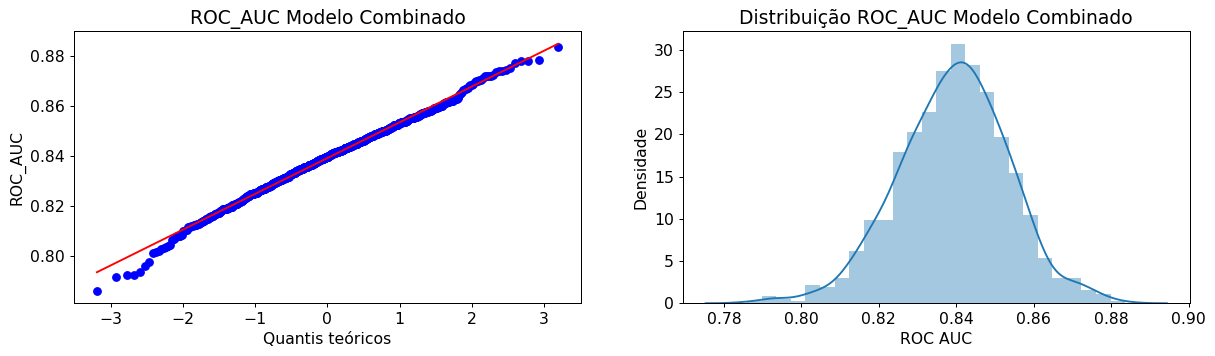

In [85]:
anderson_result = anderson(mean)

md = Markdown(f'''\

## Testes de Normalidade para as ROC_AUC obtidas com Bootstrap pelo Modelo Combinado

$\\alpha$ = 0,05\\
\\
$H_0$: $P_{{AB}} \\sim N(\\mu, \\sigma^2)$\\
$H_A$: $P_{{AB}} \\not \\sim N(\\mu, \\sigma^2)$\\
$$  
\\
$$

Ao aplicar o teste D’Agostino’s K$^2$, obtém-se $\\textit{{p-value}}={normaltest(mean)[1]:.4f}$. Sendo $\\textit{{ p-value }} < \\alpha$, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Shapiro-Wilk, obtém-se $\\textit{{p-value}}={shapiro(mean)[1]:.4f}$. Sendo $\\textit{{ p-value }} < \\alpha$, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Ao aplicar o teste Anderson-Darling, obtém-se a estatística ${anderson_result.statistic:.3f}$ e valor crítico ${anderson_result.critical_values[2]:.3f}$
para $\\alpha={anderson_result.significance_level[2]/100:.2f}$. Sendo a estatística maior que o valor crítico, para o nível de significância escolhido, 
rejeita-se $H_0$ e não é possível afirmar que os dados são provenientes de uma distribuição normal.

Assim, todos os testes e a análise gráfica não confirmam a normalidade.
''')

display(md)

fig, ax = plt.subplots(1, 2, figsize=(16,4), dpi=90, sharex=False, sharey=False)

probplot(mean, plot=ax[0])
ax[0].set_ylabel('ROC_AUC')
ax[0].set_xlabel('Quantis teóricos')
ax[0].set_title('ROC_AUC Modelo Combinado')

sns.distplot(mean, ax=ax[1])
ax[1].set_ylabel('Densidade')
ax[1].set_xlabel('ROC AUC')
ax[1].set_title('Distribuição ROC_AUC Modelo Combinado')
plt.show()

Como os dados do modelo combinado não são normais foi necessária a utilização de testes não paramétricos para a comparação das distribuições.

In [83]:
md = Markdown(f'''\

## Teste para comparação de medianas

$M_{{t}}$ = Mediana para o modelo textual\\
$M_{{c}}$ = Mediana para o modelo combinado\\
$\\alpha$ = 0,05\\

\\
$H_0$: $M_{{t}} <= M_{{c}}$\\
$H_A$: $M_{{t}} > M_{{c}}$\\
$$  
\\
$$

Ao aplicar o teste Mann Witney U obtém-se $\\textit{{p-value}}={mannwhitneyu(mean, txt, alternative='greater')[1]}$. Assim rejeita-se $H_0$ e considera-se que 
$M_{{c}}$ é significativamente maior que $M_{{t}}$.
''')

display(md)


## Teste para comparação de medianas

$M_{t}$ = Mediana para o modelo textual\
$M_{c}$ = Mediana para o modelo combinado\
$\alpha$ = 0,05\

\
$H_0$: $M_{t} <= M_{c}$\
$H_A$: $M_{t} > M_{c}$\
$$  
\
$$

Ao aplicar o teste Mann Witney U obtém-se $\textit{p-value}=5.888282225149279e-178$. Assim rejeita-se $H_0$ e considera-se que 
$M_{c}$ é significativamente maior que $M_{t}$.


In [84]:
md = Markdown(f'''\

## Teste para comparação de medianas

$M_{{t}}$ = Mediana para o modelo textual\\
$M_{{c}}$ = Mediana para o modelo combinado\\
$\\alpha$ = 0,05\\
\\
$H_0$: $M_{{t}} <= M_{{c}}$\\
$H_A$: $M_{{t}} > M_{{c}}$\\
$$
\\
$$

Ao aplicar o teste de Wilcoxon obtém-se $\\textit{{p-value}}={wilcoxon(mean, txt, alternative='greater')[1]}$. Assim rejeita-se $H_0$ e considera-se que 
$M_{{c}}$ é significativamente maior que $M_{{t}}$.
''')

display(md)




## Teste para comparação de medianas

$M_{t}$ = Mediana para o modelo textual\
$M_{c}$ = Mediana para o modelo combinado\
$\alpha$ = 0,05\
\
$H_0$: $M_{t} <= M_{c}$\
$H_A$: $M_{t} > M_{c}$\
$$
\
$$

Ao aplicar o teste de Wilcoxon obtém-se $\textit{p-value}=1.6629295594672565e-165$. Assim rejeita-se $H_0$ e considera-se que 
$M_{c}$ é significativamente maior que $M_{t}$.
